In [32]:
# -*- coding: utf-8 -*-
#-----------------------------------------------------------------------------------------------------------------------------------
'''
Description: Process the GOES-16/17 data
Author: Joao Henry Huaman Chinchay
E-mail: joaohenry23@gmail.com
Created date: Mar 23, 2020
Modification date: Jul 23, 2023
'''
#-----------------------------------------------------------------------------------------------------------------------------------
import numpy as np
from netCDF4 import Dataset, num2date
from pyproj import Proj
import datetime
import glob
import os
import warnings
import re
warnings.filterwarnings('ignore')

#-----------------------------------------------------------------------------------------------------------------------------------

class GOES():


    def __init__(self, attrs):
        for key in attrs.keys():
            setattr(self, key, attrs[key])


    def __str__(self):
        attr = []
        classes = []
        var = []
        for key in list(self.__dict__.keys()):

            if isinstance(self.__dict__[key],np.ndarray):
                var.append('   {:29} ({}) {}'.format(key, ', '.join(np.array(self.__dict__[key].shape).astype('str')), str(self.__dict__[key].dtype)))

            elif isinstance(self.__dict__[key],GOES):
                classes.append('   {:29} {}'.format(key, self.__dict__[key].__class__))

            elif isinstance(self.__dict__[key],str):
                if len(self.__dict__[key])>50 :
                    attrib = '{:.48}...'.format(self.__dict__[key])
                else:
                    attrib = '{}'.format(self.__dict__[key])
                attr.append('   {:30}: {}'.format(key, attrib))

            elif isinstance(self.__dict__[key],tuple):
                attr.append('   {:30}: ({})'.format(key, ', '.join(self.__dict__[key])))
            else:
                attr.append('   {:30}: {}'.format(key, self.__dict__[key]))

        return '\n'.join([str(self.__class__)]+['']+['Keys:']+attr+classes+var+[''])



    def __repr__(self):
        attr = []
        classes = []
        var = []
        for key in list(self.__dict__.keys()):

            if isinstance(self.__dict__[key],np.ndarray):
                var.append('   {:29} ({}) {}'.format(key, ', '.join(np.array(self.__dict__[key].shape).astype('str')), str(self.__dict__[key].dtype)))

            elif isinstance(self.__dict__[key],GOES):
                classes.append('   {:29} {}'.format(key, self.__dict__[key].__class__))

            elif isinstance(self.__dict__[key],str):
                if len(self.__dict__[key])>50 :
                    attrib = '{:.48}...'.format(self.__dict__[key])
                else:
                    attrib = '{}'.format(self.__dict__[key])
                attr.append('   {:30}: {}'.format(key, attrib))

            elif isinstance(self.__dict__[key],tuple):
                attr.append('   {:30}: ({})'.format(key, ', '.join(self.__dict__[key])))
            else:
                attr.append('   {:30}: {}'.format(key, self.__dict__[key]))

        return '\n'.join([str(self.__class__)]+['']+['Keys:']+attr+classes+var+[''])



    def refl_fact_to_refl(self, Lons, Lats, MinCosTheta=0.0, fmt=np.float32):

        '''

        It converts reflectance factor to reflectance.

        Parameters
        ----------
        Lons : ndarray
            A scalar 2-D array with center longitude of pixel.

        Lats : ndarray
            A scalar 2-D array with center latitude of pixel.

        MinCosTheta : float, optional, default 0.0
            Minimum valid value of the cosine of theta.

        fmt : dtype, optional, default np.float32
            The type of the returns.

        Returns
        -------
        reflectance : object
            reflectance.

        '''

        if self.long_name == 'ABI L2+ Cloud and Moisture Imagery reflectance factor':

            try:
                assert self.data.shape == Lons.data.shape == Lats.data.shape
            except AssertionError:
                print('\n\tShape of Lon, Lat and data do not match.\n')
                return
            else:
                dict_Field = {'long_name':'ABI L2+ Cloud and Moisture Imagery reflectance', 'standard_name':'toa_lambertian_equivalent_albedo',
                              'units':1, 'undef':np.nan, 'axis':'YX', 't':self.t, 'time_bounds':self.time_bounds, 'pixels_limits':self.pixels_limits, 'dimensions':('y','x'),
                              'data':self.data/cosine_of_solar_zenith_angle(Lons.data, Lats.data, self.t.data, MinCosTheta=MinCosTheta, fmt=fmt).data}
                return GOES(dict_Field);

        else:
            print('\n\tIt is not possible convert Data because is not ABI L2+ Cloud and Moisture Imagery reflectance factor\n')



    def keys(self):
        return list(self.__dict__.keys())


#-----------------------------------------------------------------------------------------------------------------------------------

class open_dataset():

    def __init__(self, File):
        self.ds = Dataset(File)


    def attribute(self, parameter):

        '''

        It gets attribute from file.

        Parameters
        ----------
        parameter: str
            Name of attribute


        Returns
        -------
        Value of attribute

        '''

        ds = self.ds
        try:
            assert parameter in ds.ncattrs()
        except AssertionError:
            print('\n\tParameter not found, check if it is an attribute\n')
            return
        else:
            return getattr(ds,parameter);



    def dimension(self, parameter):

        '''

        It gets dimension from file.

        Parameters
        ----------
        parameter: str
            Name of dimension


        Returns
        -------
        parameter: str
            Value of dimension

        '''

        ds = self.ds
        try:
            assert parameter in ds.dimensions.keys()
        except AssertionError:
            print('\n\tParameter not found, check if it is a dimension\n')
            return
        else:
            parameter = ds.dimensions[parameter]
            return GOES({'name':parameter.name, 'size':parameter.size});




    def group(self, parameter):

        '''

        It gets group from file.

        Parameters
        ----------
        parameter: str
            Name of group


        Returns
        -------
        parameter: str
            Value of group

        '''

        ds = self.ds
        try:
            assert parameter in ds.groups.keys()
        except AssertionError:
            print('\n\tParameter not found, check if it is a group\n')
            return
        else:
            return ds.groups[parameter];





    def variable(self, parameter):

        '''

        It gets variable from file.

        Parameters
        ----------
        parameter: str
            Name of variable


        Returns
        -------
        parameter: str
            Value of variable

        '''

        ds = self.ds
        try:
            assert parameter in ds.variables.keys()
        except AssertionError:
            print('\n\tParameter not found, check if it is a variable\n')
            return
        else:
            try:
                assert ds.variables[parameter].dimensions != ('y','x') #(ds.variables[parameter].ndim == 0) or (ds.variables[parameter].ndim == 1)
            except AssertionError:
                print('\n\tParameter is not a variable\n')
                return
            else:
                parameter = ds.variables[parameter]
                fmt = parameter[:].dtype
                data = np.where(parameter[:].mask==True, np.nan, parameter[:].data)
                IsDateTime = False

                if 'units' in parameter.ncattrs():
                    if 'seconds since' in parameter.units:
                        data = num2date(data, parameter.units, 'standard', only_use_cftime_datetimes=False, only_use_python_datetimes=True)
                        fmt = object
                        data = np.array(data)
                        IsDateTime = True
                        #if isinstance(data, np.ma.core.MaskedArray):
                        #    data = np.array(data)
                        #if isinstance(data, datetime.datetime):
                        #    data = np.array(data)
                else:
                    if 'long_name' in parameter.ncattrs():
                        if 'seconds since' in parameter.long_name or 'time' in parameter.long_name:
                            if '(' and ')' in parameter.long_name:
                                units = 'seconds since '+re.findall(r'\(.+?\)',parameter.long_name)[0][1:-1]
                            else:
                                units = 'seconds since 2000-01-01 12:00:00'
                            data = num2date(data, units, 'standard', only_use_cftime_datetimes=False, only_use_python_datetimes=True)
                            fmt = object
                            data = np.array(data)
                            IsDateTime = True
                            #if isinstance(data, np.ma.core.MaskedArray):
                            #    data = np.array(data)
                            #if isinstance(data, datetime.datetime):
                            #    data = np.array(data)

                dict = {}
                for key in parameter.__dict__.keys():
                    dict.update({key: getattr(parameter,key)})

                if IsDateTime == True:
                    if 'units' in dict:
                        del dict['units']

                for item in ['_Unsigned','scale_factor','add_offset','_FillValue']:
                    if item in dict:
                        del dict[item]

                dict.update({'dimensions': getattr(parameter,'dimensions')})

                if data.ndim == 0:
                    data = data.reshape([1])
                    dict.update({'data':data[0]})
                else:
                    dict.update({'data':data.astype(fmt)})

                return GOES(dict);




    def image(self, parameter, lonlat='center', domain=None, domain_in_pixels=None, up_level=False, nan_mask=None, delta_index=4, fmt=np.float32):

        '''

        It gets image from dataset with its longitude and latitude information.

        Parameters
        ----------
        parameter : str
            Name of image.

        lonlat: str, optional, default 'center'
            Define if longitud and latitud of parameter are return.
            If lonlat='center' return center of each pixel of parameter.
            If lonlat='corner' return corners of each of pixel parameter.
            If lonlat=None return None values instead of latitud and longitud.

        domain : list or None, optional, default None
            List with coordinates of domain that you want to select.
            Example:
            domain = [LLLon, URLon, LLLat, URLat]
                 
            Where:

                LLLon : float
                          Lower left longitude of domain.

                URLon : float
                          Upper right longitude of domain.

                LLLat : float
                          Lower left latitude of domain.

                URLat : float
                          Upper right latitude of domain.


        domain_in_pixels : list, numpy.ndarray or None, optional, default None
            List or numpy.ndarray with the pixels position index of domain that
            you want to select.
            Example:
            domain_in_pixels = [XMIN, XMAX, YMIN, YMAX]
                 
            Where:

                XMIN : int
                          Lower left pixel of domain.

                XMAX : int
                          Upper right pixel of domain.

                YMIN : int
                          Lower left pixel of domain.

                YMAX : int
                          Upper right pixel of domain.


        up_level : boolean, optional, default False
            If parameter is an L1b ABI channel (Rad), then up_level=True
            convert this parameter to L2 product. If this parameter correspond
            to channels 01-06, the L2 product will be the Reflectance Factor,
            but if correspond to channels 07-16, then L2 product will be the
            brightness temperature.

        nan_mask : numpy.ndarray or None, optional, default None
            When lonlat=None, the latitude and longitude information is absent,
            which prevents to know the image pixels with incorrect geographic
            information. To solved this, nan_mask must be a np.ndarray with
            True or False values and it must be the same size as the returned
            image. The True values of nan_mask indicate the image pixels that
            will be convert to nan. If nan_mask=None, nothing is done.

        delta_index : int, optional, default 4
            Interval between indexes of arrays, used to locate
            more quickly the index of satellite region that will be slice.

        fmt : dtype, optional, default np.float32
            The type of the returns (Field, Lons and Lats).


        Returns
        -------
        Field : object
            A scalar 2-D array.

        Lons : object
            A scalar 2-D array with longitude of Field.

        Lats : object
            A scalar 2-D array with latitude of Field.

        '''

        ds = self.ds

        try:
            assert parameter in ds.variables.keys()
        except AssertionError:
            print('\n\tParameter not found, check if it is an image\n')
            return
        else:

            try:
                assert ('y','x') == ds.variables[parameter].dimensions
            except AssertionError:
                print("\n\t{} is not a valid product because have not ('y','x') dimensions\n".format(parameter))
                return
            else:
                ProcessingLevel = ds.processing_level.split(' ')[-1]
                PlatformID = ds.platform_ID
                SatHeight = ds.variables['goes_imager_projection'].perspective_point_height
                SatLon = ds.variables['goes_imager_projection'].longitude_of_projection_origin
                SatSweep = ds.variables['goes_imager_projection'].sweep_angle_axis

                X = ds.variables['x']
                Y = ds.variables['y']
                xsize = X.shape[0]
                ysize = Y.shape[0]
                #------------------------------------------------------------------
                # gets attributes of Field
                dict_Field = {'long_name':None, 'standard_name':None,
                              'units':None, 'undef':np.nan, 'pixels_limits':None, 'axis':'YX',
                              't':None, 'time_bounds':None, 'dimensions':('y','x'), 'data':None}

                dict_Field['t'] = self.variable('t')
                dict_Field['time_bounds'] = self.variable('time_bounds')

                #------------------------------------------------------------------

                for item in ds.variables[parameter].ncattrs():
                    if item in dict_Field.keys():
                        dict_Field[item] = getattr(ds.variables[parameter],item)

                #------------------------------------------------------------------

                if isinstance(domain, list) or isinstance(domain, np.ndarray):

                    LLLon, URLon, LLLat, URLat = domain
                    Lons, Lats = get_lonlat(X[::delta_index].astype(fmt), Y[::delta_index].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)

                    xpixmin, xpixmax, ypixmin, ypixmax = find_pixels_of_region(Lons, Lats, LLLon, URLon, LLLat, URLat)
                    del Lons, Lats

                    xini = xpixmin*delta_index
                    xfin = (xpixmax+1)*delta_index -1
                    yini = ypixmin*delta_index
                    yfin = (ypixmax+1)*delta_index -1

                    #- - - - - - - - - - - - - - - - - - -
                    # add and decrease pixels to improve the search of pixels of interest region
                    if xini - delta_index < 0:
                        xini = 0
                    else:
                        xini = xini - delta_index


                    if xfin + delta_index > xsize-1:
                        xfin = xsize-1
                    else:
                        xfin = xfin + delta_index



                    if yini - delta_index < 0:
                        yini = 0
                    else:
                        yini = yini - delta_index


                    if yfin + delta_index > ysize-1:
                        yfin = ysize-1
                    else:
                        yfin = yfin + delta_index

                    #- - - - - - - - - - - - - - - - - - -

                    Lons, Lats = get_lonlat(X[xini:xfin+1].astype(fmt), Y[yini:yfin+1].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)

                    xpixmin, xpixmax, ypixmin, ypixmax = find_pixels_of_region(Lons, Lats, LLLon, URLon, LLLat, URLat)
                    Limits = np.array([xini+xpixmin, xini+xpixmax, yini+ypixmin, yini+ypixmax])
                    dict_Field['pixels_limits'] = Limits


                    if lonlat == 'center':
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats
                        dict_Lons.data = np.ascontiguousarray(Lons.data[ypixmin:ypixmax+1,xpixmin:xpixmax+1], dtype=fmt)
                        dict_Lats.data = np.ascontiguousarray(Lats.data[ypixmin:ypixmax+1,xpixmin:xpixmax+1], dtype=fmt)

                    elif lonlat == 'corner':
                        Lons, Lats = get_lonlatcorner(X[xini+xpixmin:xini+xpixmax+1].astype(fmt), Y[yini+ypixmin:yini+ypixmax+1].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats


                elif isinstance(domain_in_pixels, list) or isinstance(domain_in_pixels, np.ndarray):

                    xpixmin, xpixmax, ypixmin, ypixmax = domain_in_pixels
                    Limits = np.array([xpixmin, xpixmax, ypixmin, ypixmax])
                    dict_Field['pixels_limits'] = Limits

                    if lonlat == 'center':
                        Lons, Lats = get_lonlat(X[xpixmin:xpixmax+1].astype(fmt), Y[ypixmin:ypixmax+1].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats

                    elif lonlat == 'corner':
                        Lons, Lats = get_lonlatcorner(X[xpixmin:xpixmax+1].astype(fmt), Y[ypixmin:ypixmax+1].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats

                else:

                    xpixmin, xpixmax, ypixmin, ypixmax = 0, xsize-1, 0, ysize-1
                    Limits = np.array([xpixmin, xpixmax, ypixmin, ypixmax])
                    dict_Field['pixels_limits'] = Limits

                    if lonlat == 'center':
                        Lons, Lats = get_lonlat(X[:].astype(fmt), Y[:].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats

                    elif lonlat == 'corner':
                        Lons, Lats = get_lonlatcorner(X[:].astype(fmt), Y[:].astype(fmt), PlatformID, SatLon, SatHeight, SatSweep, fmt=fmt)
                        del X, Y
                        dict_Lons = Lons
                        dict_Lats = Lats

                #------------------------------------------------------------------

                if up_level == True:

                    try:
                        assert ProcessingLevel == 'L1b'
                    except AssertionError:
                        print('\n\tWas not possible increase level of {} because is not L1b.\n'.format(parameter))
                        return
                    else:
                        if ds.variables['band_id'][0].data < 7:
                            dict_Field['long_name'] = 'ABI L2+ Cloud and Moisture Imagery reflectance factor'
                            dict_Field['standard_name'] = 'toa_lambertian_equivalent_albedo_multiplied_by_cosine_solar_zenith_angle'
                            dict_Field['units'] = '1'
                            kappa = ds.variables['kappa0'][:]
                            Field = kappa*ds.variables[parameter][Limits[2]:Limits[3]+1,Limits[0]:Limits[1]+1].astype(dtype=fmt)
                        else:
                            dict_Field['long_name'] = 'ABI L2+ Cloud and Moisture Imagery brightness temperature'
                            dict_Field['standard_name'] = 'toa_brightness_temperature'
                            dict_Field['units'] = 'K'
                            planck_fk1 = ds.variables['planck_fk1'][:]
                            planck_fk2 = ds.variables['planck_fk2'][:]
                            planck_bc1 = ds.variables['planck_bc1'][:]
                            planck_bc2 = ds.variables['planck_bc2'][:]
                            Field = (planck_fk2/(np.log( (planck_fk1/ds.variables[parameter][Limits[2]:Limits[3]+1,Limits[0]:Limits[1]+1].astype(dtype=fmt)) +1 )) - planck_bc1)/planck_bc2

                else:
                    dict_Field['long_name'] = ds.variables[parameter].long_name
                    dict_Field['standard_name'] = ds.variables[parameter].standard_name
                    dict_Field['units'] = ds.variables[parameter].units
                    Field = ds.variables[parameter][Limits[2]:Limits[3]+1,Limits[0]:Limits[1]+1].astype(dtype=fmt)

                #------------------------------------------------------------------

                if lonlat == 'center':
                    Field = np.where((Field[:].mask==True)|(Lons.data==-999.99), np.nan, Field[:])
                    Field = np.ascontiguousarray(Field, dtype=fmt)
                    dict_Field['data'] = Field
                    return GOES(dict_Field), dict_Lons, dict_Lats;

                elif lonlat == 'corner':
                    mask = np.where(Lons.data<-990.0, True, False)
                    mask = corner_size_to_center_size(mask)
                    Field = np.where((Field[:].mask==True)|(mask==True), np.nan, Field[:])
                    Field = np.ascontiguousarray(Field, dtype=fmt)
                    dict_Field['data'] = Field
                    return GOES(dict_Field), dict_Lons, dict_Lats;

                else:

                    if isinstance(nan_mask,np.ndarray):
                        if Field[:].size == nan_mask.size:
                            Field = np.where((Field[:].mask==True)|(nan_mask==True), np.nan, Field[:])
                        else:
                            print('The size of the nan_mask does not match the size of the returned image. Masking will not be done.')
                            Field = np.where((Field[:].mask==True), np.nan, Field[:])
                    else:
                        Field = np.where((Field[:].mask==True), np.nan, Field[:])

                    Field = np.ascontiguousarray(Field, dtype=fmt)
                    dict_Field['data'] = Field
                    dict_Lons = None
                    dict_Lats = None
                    return GOES(dict_Field), None, None;




    def __str__(self):

        ds = self.ds
        attr = ['attribute:']
        dims = ['dimension:']
        var0D = ['variable:']
        var1D = []
        var2D = []
        varMD = []
        image = ['image:']
        group = ['group:']

        for item in ds.ncattrs():
            attrib = getattr(ds,item)
            if len(attrib)>50 :
                attrib = '{:.48}...'.format(attrib)
            attr.append('   {:30}: {}'.format(item, attrib))

        for item in ds.dimensions.keys():
            dims.append('   {:50} ({})'.format(item, ds.dimensions[item].size))

        for item in ds.variables.keys():
            if ds.variables[item].ndim == 0:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var0D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 1:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var1D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 2:
                if ds.variables[item].dimensions == ('y','x') :
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    image.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
                else:
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    var2D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim > 2:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                varMD.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))

        for item in ds.groups.keys():
            groups.append('   {:50}'.format(item))

        return '\n'.join([str(self.__class__)]+['']+attr+['']+dims+['']+var0D+var1D+var2D+varMD+['']+image+['']+group+[''])



    def __repr__(self):

        ds = self.ds
        attr = ['attribute:']
        dims = ['dimension:']
        var0D = ['variable:']
        var1D = []
        var2D = []
        varMD = []
        image = ['image:']
        group = ['group:']

        for item in ds.ncattrs():
            attrib = getattr(ds,item)
            if len(attrib)>50 :
                attrib = '{:.48}...'.format(attrib)
            attr.append('   {:30}: {}'.format(item, attrib))

        for item in ds.dimensions.keys():
            dims.append('   {:50} ({})'.format(item, ds.dimensions[item].size))

        for item in ds.variables.keys():
            if ds.variables[item].ndim == 0:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var0D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 1:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var1D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 2:
                if ds.variables[item].dimensions == ('y','x') :
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    image.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
                else:
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    var2D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim > 2:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                varMD.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))

        for item in ds.groups.keys():
            groups.append('   {:50}'.format(item))

        return '\n'.join([str(self.__class__)]+['']+attr+['']+dims+['']+var0D+var1D+var2D+varMD+['']+image+['']+group+[''])



    def keys(self):
        return list(self.__dict__.keys())


#-----------------------------------------------------------------------------------------------------------------------------------

class open_mfdataset():

    def __init__(self, FList):
        try:
            assert isinstance(FList,list)
        except AssertionError:
            print('\n\tFList must be a list\n')
            return
        else:
            ds = []
            for File in FList:
                try:
                    assert 'GLM' in File
                except AssertionError:
                    print('\n\topen_mfdataset just work with GLM files\n')
                    return
                else:
                    ds.append(Dataset(File))

            self.ds = ds
            self.files = FList




    def attribute(self, parameter):

        '''

        It gets attribute from file.

        Parameters
        ----------
        parameter: str
            Name of attribute


        Returns
        -------
        Value of attribute

        '''

        mfparameter = []
        for idx in range(len(self.ds)):
            ds = self.ds[idx]
            try:
                assert parameter in ds.ncattrs()
            except AssertionError:
                print('\n\tParameter not found, check if it is an attribute\n')
                return
            else:
                mfparameter.append(getattr(ds,parameter))
        return mfparameter;



    def dimension(self, parameter):

        '''

        It gets dimension from file.

        Parameters
        ----------
        parameter: str
            Name of dimension


        Returns
        -------
        parameter: str
            Value of dimension

        '''

        mfparameter_name = []
        mfparameter_size = []
        for idx in range(len(self.ds)):
            ds = self.ds[idx]
            try:
                assert parameter in ds.dimensions.keys()
            except AssertionError:
                print('\n\tParameter not found, check if it is a dimension\n')
                print(list(ds.dimensions.keys()))
                return
            else:
                mfparameter_name.append(ds.dimensions[parameter].name)
                mfparameter_size.append(ds.dimensions[parameter].size)
        return GOES({'name':np.array(mfparameter_name), 'size':np.array(mfparameter_size)});



    def group(self, parameter):

        '''

        It gets group from file.

        Parameters
        ----------
        parameter: str
            Name of group


        Returns
        -------
        parameter: str
            Value of group

        '''

        mfparameter = []
        for idx in range(len(self.ds)):
            ds = self.ds[idx]
            try:
                assert parameter in ds.groups.keys()
            except AssertionError:
                print('\n\tParameter not found, check if it is a group\n')
                return
            else:
                mfparameter.append(ds.groups[parameter])
        return mfparameter;




    def variable(self, parameter):

        '''

        It gets variable from file.

        Parameters
        ----------
        parameter: str
            Name of variable


        Returns
        -------
        parameter: str
            Value of variable

        '''

        for idx in range(len(self.ds)):
            ds = self.ds[idx]
            try:
                assert parameter in ds.variables.keys()
            except AssertionError:
                print('\n\tParameter not found, check if it is a variable\n')
                return
            else:
                try:
                    assert ds.variables[parameter].dimensions != ('y','x')
                    #assert (ds.variables[parameter].ndim == 0) or (ds.variables[parameter].ndim == 1)
                except AssertionError:
                    print('\n\tParameter is not a variable\n')
                    return
                else:
                    mfparameter = ds.variables[parameter]
                    fmt = mfparameter[:].dtype
                    data = np.where(mfparameter[:].mask==True, np.nan, mfparameter[:].data)
                    IsDateTime = False

                    if 'units' in mfparameter.ncattrs():
                        if 'seconds since' in mfparameter.units:
                            data = num2date(data, mfparameter.units, 'standard', only_use_cftime_datetimes=False, only_use_python_datetimes=True)
                            fmt = object
                            data = np.array(data)
                            IsDateTime = True
                            #if isinstance(data, np.ma.core.MaskedArray):
                            #    data = np.array(data)
                            #if isinstance(data, datetime.datetime):
                            #    data = np.array(data)#([data])
                    else:
                        if 'long_name' in mfparameter.ncattrs():
                            if 'seconds since' in mfparameter.long_name or 'time' in mfparameter.long_name:
                                if '(' and ')' in mfparameter.long_name:
                                    units = 'seconds since '+re.findall(r'\(.+?\)',mfparameter.long_name)[0][1:-1]
                                else:
                                    units = 'seconds since 2000-01-01 12:00:00'
                                data = num2date(data, units, 'standard', only_use_cftime_datetimes=False, only_use_python_datetimes=True)
                                fmt = object
                                data = np.array(data)
                                IsDateTime = True
                                #if isinstance(data, np.ma.core.MaskedArray):
                                #    data = np.array(data)
                                #if isinstance(data, datetime.datetime):
                                #    data = np.array(data)#([data])

                    if data.ndim == 0:
                        data = data.reshape([1]) #np.array([data])
                    elif data.ndim == 1:
                        if 'bounds' in mfparameter.dimensions[0]:
                            data = data.reshape([1,2])

            if idx == 0 :
                mfdata = data
            else:
                mfdata = np.concatenate((mfdata,data))

        dict = {}
        for key in mfparameter.__dict__.keys():
            dict.update({key: getattr(mfparameter,key)})

        if IsDateTime == True:
            if 'units' in dict:
                del dict['units']

        for item in ['_Unsigned','scale_factor','add_offset','_FillValue']:
            if item in dict:
                del dict[item]

        if len(getattr(mfparameter,'dimensions')) == 0:
            dict.update({'dimensions': ('number_of_files',)})
        elif len(getattr(mfparameter,'dimensions')) == 1:
            if 'bounds' in mfparameter.dimensions[0]:
                dict.update({'dimensions': ('number_of_files',getattr(mfparameter,'dimensions')[0])})
            else:
                dict.update({'dimensions': getattr(mfparameter,'dimensions')})
        else:
            dict.update({'dimensions': getattr(mfparameter,'dimensions')})

        dict.update({'data':mfdata.astype(fmt)})

        return GOES(dict);



    def image(self, parameter):

        '''

        It gets image from file, however, in this case, this method is disable because the files was open with open_mfdataset().

        '''
        print('\nThe image() method is disable for open_mfdataset(). Open the file with open_dataset() if you wan to use the image() method.\n')
        return None, None, None;



    def __str__(self):

        nfiles = len(self.ds) #for idx in range(len(self.ds)):
        ds = self.ds[0]
        nf = ['number files: '+str(nfiles)]
        files = self.files
        attr = ['attribute:']
        dims = ['dimension:']
        var0D = ['variable:']
        var1D = []
        var2D = []
        varMD = []
        image = ['image:']
        group = ['group:']

        for item in ds.ncattrs():
            attr.append('   {:30}'.format(item))

        for item in ds.dimensions.keys():
            dims.append('   {:50}'.format(item))

        for item in ds.variables.keys():
            if ds.variables[item].ndim == 0:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var0D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 1:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var1D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 2:
                if ds.variables[item].dimensions == ('y','x'):
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    image.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
                else:
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    var2D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim > 2:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                varMD.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))

        for item in ds.groups.keys():
            groups.append('   {:50}'.format(item))

        return '\n'.join([str(self.__class__)]+['']+nf+files+['']+attr+['']+dims+['']+var0D+var1D+var2D+varMD+['']+image+['']+group+[''])



    def __repr__(self):

        nfiles = len(self.ds) #for idx in range(len(self.ds)):
        ds = self.ds[0]
        nf = ['number files: '+str(nfiles)]
        files = self.files
        attr = ['attribute:']
        dims = ['dimension:']
        var0D = ['variable:']
        var1D = []
        var2D = []
        varMD = []
        image = ['image:']
        group = ['group:']

        for item in ds.ncattrs():
            attr.append('   {:30}'.format(item))

        for item in ds.dimensions.keys():
            dims.append('   {:50}'.format(item))

        for item in ds.variables.keys():
            if ds.variables[item].ndim == 0:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var0D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 1:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                var1D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim == 2:
                if ds.variables[item].dimensions == ('y','x'):
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    image.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
                else:
                    size = '({})'.format(', '.join(ds.variables[item].dimensions))
                    var2D.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))
            elif ds.variables[item].ndim > 2:
                size = '({})'.format(', '.join(ds.variables[item].dimensions))
                varMD.append('   {:50} {} {}'.format(item, size, ds.variables[item].dtype))

        for item in ds.groups.keys():
            groups.append('   {:50}'.format(item))

        return '\n'.join([str(self.__class__)]+['']+nf+files+['']+attr+['']+dims+['']+var0D+var1D+var2D+varMD+['']+image+['']+group+[''])



    def keys(self):
        return list(self.__dict__.keys())

#-----------------------------------------------------------------------------------------------------------------------------------

def get_lonlat(X, Y, PlatformID, SatLon, SatHeight, SatSweep, fmt=np.float32):

    '''

    Calculates the longitude and latitude of the center of the pixels,
    corresponding to the satellite image, using the fixed grid East/West and
    North/South scanning angle in radians of pixels.


    Parameters
    ----------
    X : ndarray
        A scalar 1-D array with the fixed grid East/West scanning
        angle in radians.

    Y : ndarray
        A scalar 1-D array with the fixed grid North/South scanning
        angle in radians.

    PlatformID : str
        Platform ID of satelite. Example: 'G16', 'G17' or 'G18'.

    SatLon : float
        Longitude of satellite in the nadir.

    SatHeight : float
        Height of satellite in meters.

    SatSweep : str
        Sweep-angle axis.

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    -------
    Lons : dict
        Scalar 2-D array with the center longitude of the pixels.
        Undefined data are set as -999.99.

    Lats : dict
        Scalar 2-D array with the center latitude of the pixels.
        Undefined data are set as -999.99.

    '''

    X = X[:]*SatHeight
    Y = Y[:]*SatHeight
    X, Y = np.meshgrid(X, Y)
    proj = Proj(proj='geos', h=SatHeight, lon_0=SatLon, sweep=SatSweep)
    Lons, Lats = proj(X, Y, inverse=True)

    if PlatformID == 'G17' or PlatformID == 'G18':
        Lons = np.where(Lons>0,Lons-360,Lons)

    Lons = np.where((Lons>=-360.0)&(Lons<=360.0)&(Lats>=-90.0)&(Lats<=90.0),Lons,-999.99).astype(fmt)
    Lats = np.where((Lons>=-360.0)&(Lons<=360.0)&(Lats>=-90.0)&(Lats<=90.0),Lats,-999.99).astype(fmt)

    dict_Lons = {'long_name':'Longitude of center of pixels', 'standard_name':'pixels center longitude',
                 'units':'degrees_east', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lons}

    dict_Lats = {'long_name':'Latitude of center of pixels', 'standard_name':'pixels center latitude',
                 'units':'degrees_north', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lats}

    return GOES(dict_Lons), GOES(dict_Lats);

#-----------------------------------------------------------------------------------------------------------------------------------

def get_lonlatcorner(X, Y, PlatformID, SatLon, SatHeight, SatSweep, fmt=np.float32):

    '''

    Calculates the longitude and latitude of the corners of the pixels,
    corresponding to the satellite image, using the fixed grid East/West and
    North/South scanning angle in radians of pixels.


    Parameters
    ----------
    X : ndarray
        A scalar 1-D array with the fixed grid East/West scanning
        angle in radians.

    Y : ndarray
        A scalar 1-D array with the fixed grid North/South scanning
        angle in radians.

    PlatformID : str
        Platform ID of satelite. Example: 'G16', 'G17' or 'G18'.

    SatLon : float
        Longitude of satellite in the nadir.

    SatHeight : float
        Height of satellite in meters.

    SatSweep : str
        Sweep-angle axis.

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    -------
    Lons : dict
        Scalar 2-D array with the center longitude of the pixels.
        Undefined data are set as -999.99.

    Lats : dict
        Scalar 2-D array with the center latitude of the pixels.
        Undefined data are set as -999.99.

    '''

    X = X[:]*SatHeight
    Y = Y[:]*SatHeight
    dx = X[1]-X[0]
    dy = Y[1]-Y[0]
    XCor = np.concatenate([X, [X[-1]+dx]])-dx/2
    YCor = np.concatenate([Y, [Y[-1]+dy]])-dy/2
    XCor, YCor = np.meshgrid(XCor, YCor)
    proj = Proj(proj='geos', h=SatHeight, lon_0=SatLon, sweep=SatSweep)
    Lons, Lats = proj(XCor, YCor, inverse=True)

    if PlatformID == 'G17' or PlatformID == 'G18':
        Lons = np.where(Lons>0,Lons-360,Lons)

    Lons = np.where((Lons>=-360.0)&(Lons<=360.0)&(Lats>=-90.0)&(Lats<=90.0),Lons,-999.99).astype(fmt)
    Lats = np.where((Lons>=-360.0)&(Lons<=360.0)&(Lats>=-90.0)&(Lats<=90.0),Lats,-999.99).astype(fmt)

    dict_Lons = {'long_name':'Longitude of corners of pixels', 'standard_name':'pixels corners longitude',
                 'units':'degrees_east', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lons}

    dict_Lats = {'long_name':'Latitude of corners of pixels', 'standard_name':'pixels corners latitude',
                 'units':'degrees_north', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lats}

    return GOES(dict_Lons), GOES(dict_Lats);

#-----------------------------------------------------------------------------------------------------------------------------------

def corner_size_to_center_size(Field):

    '''

    Reduce dimension of array from [m,n] to [m-1,n-1]. Where m and n are odd numbers.

    Parameters
    ----------
    Field : ndarray
        A scalar 2-D array with dimension [m,n].

    Returns
    ----------
    Field with size [m-1,n-1]
    '''

    ny, nx = Field.shape
    ny = ny - 1
    nx = nx - 1
    Field = np.concatenate((Field[:,0:int(nx/2.0)], Field[:,int(nx/2.0)+1:]),axis=1)
    Field = np.concatenate((Field[0:int(ny/2.0),:], Field[int(ny/2.0)+1:,:]),axis=0)
    return Field;

#-----------------------------------------------------------------------------------------------------------------------------------

def midpoint_in_x(Field, fmt=np.float32):

    '''

    Calculates the middle value between pixels in X axis.

    Parameters
    ----------
    Field : ndarray
        A scalar 2-D array with dimension [m,n].

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    ----------
    midpoint : ndarray
        A scalar 2-D array with dimension [m,n+1]. Undefined data
        are set as -999.99.

    '''

    Field = np.array(Field,dtype=fmt)
    Field = np.column_stack((Field, np.full([Field.shape[0],1],-999.99,dtype=fmt)))
    right = np.column_stack((Field[:,1:], np.full([Field.shape[0],1],-999.99,dtype=fmt)))
    left = np.column_stack((np.full([Field.shape[0],1],-999.99,dtype=fmt), Field[:,:-1]))
    left2 = np.column_stack((np.full([Field.shape[0],2],-999.99,dtype=fmt), Field[:,:-2]))

    midpoint = np.where((Field>-400.0)&(left<-400.0),Field-(right-Field)/2.0,-999.99)
    midpoint = np.where((Field>-400.0)&(left>-400.0),(left+Field)/2.0,midpoint)
    midpoint = np.where((Field<-400.0)&(left>-400.0),left+(left-left2)/2.0,midpoint)
    return midpoint;


def midpoint_in_y(Field, fmt=np.float32):

    '''

    Calculates the middle value between pixels in Y axis.

    Parameters
    ----------
    Field : ndarray
        A scalar 2-D array with dimension [m,n].

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    ----------
    midpoint : ndarray
        A scalar 2-D array with dimension [m+1,n]. Undefined data
        are set as -999.99.

    '''

    Field = np.array(Field,dtype=fmt)
    Field = np.vstack((Field, np.full([1,Field.shape[1]],-999.99,dtype=fmt)))
    lower = np.vstack((Field[1:,:], np.full([1,Field.shape[1]],-999.99,dtype=fmt)))
    upper = np.vstack((np.full([1,Field.shape[1]],-999.99,dtype=fmt), Field[:-1,:]))
    upper2 = np.vstack((np.full([2,Field.shape[1]],-999.99,dtype=fmt), Field[:-2,:]))

    midpoint = np.where((Field>-400.0)&(upper<-400.0),Field-(lower-Field)/2.0,-999.99)
    midpoint = np.where((Field>-400.0)&(upper>-400.0),(upper+Field)/2.0,midpoint)
    midpoint = np.where((Field<-400.0)&(upper>-400.0),upper+(upper-upper2)/2.0,midpoint)
    return midpoint;

#-----------------------------------------------------------------------------------------------------------------------------------

def calculate_corners(Lons, Lats, fmt=np.float32):

    '''

    Calculates corners of pixels of the satellite image, from the longitude and latitude
    of the center of the pixels.


    Parameters
    ----------
    Lons : ndarray
        Scalar 2-D array with the center longitude of the pixels of
        the satellite image.

    Lats : ndarray
        Scalar 2-D array with the center latitude of the pixels of
        the satellite image.

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    -------
    Lons : object
        A scalar 2-D array with the longitude of the corners of the pixels of
        the satellite image.

    Lats : obejct
        A scalar 2-D array with the latitude of the corners of the pixels of
        the satellite image.

    '''


    try:
        assert (isinstance(Lons,GOES)==isinstance(Lats,GOES)==True) or (isinstance(Lons,np.ndarray)==isinstance(Lats,np.ndarray)==True)
    except AssertionError:
        print('\nLons and Lats must be GOES class or numpy.ndarray\n')
        return
    else:
        if isinstance(Lons,GOES) and isinstance(Lats,GOES):
            Lons = Lons.data
            Lats = Lats.data

        Lons = midpoint_in_x(Lons, fmt=fmt)
        Lats = midpoint_in_y(Lats, fmt=fmt)

        Lons = midpoint_in_y(Lons, fmt=fmt)
        Lats = midpoint_in_x(Lats, fmt=fmt)

        dict_Lons = {'long_name':'Longitude of corners of pixels', 'standard_name':'pixels corners longitude',
                     'units':'degrees_east', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lons}

        dict_Lats = {'long_name':'Latitude of corners of pixels', 'standard_name':'pixels corners latitude',
                     'units':'degrees_north', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':Lats}

        return GOES(dict_Lons), GOES(dict_Lats);

#-----------------------------------------------------------------------------------------------------------------------------------

def find_pixel_of_coordinate(Lons, Lats, LonCoord, LatCoord):

    '''

    Finds the X and Y index of the pixel closest to the required coordinate.

    Parameters
    ----------
    Lons : ndarray
        A scalar 2-D array with the longitude of the center of the pixels of
        the satellite image.

    Lats : ndarray
        A scalar 2-D array with the latitude of the center of the pixels of
        the satellite image.

    LonCoord : float
        Longitude of the required coordinate.

    LatCoord : float
        Latitude of the required coordinate.


    Returns
    -------
    xpix : int
        Index on the X axis of the pixel closest to the required coordinate.

    ypix : int
        Index on the Y axis of the pixel closest to the required coordinate.

    '''


    try:
        assert (isinstance(Lons,GOES)==isinstance(Lats,GOES)==True) or (isinstance(Lons,np.ndarray)==isinstance(Lats,np.ndarray)==True)
    except AssertionError:
        print('\nLons and Lats must be GOES class or numpy.ndarray\n')
        return
    else:
        if isinstance(Lons,GOES) and isinstance(Lats,GOES):
            Lons = Lons.data
            Lats = Lats.data

        Dist = np.sqrt( (Lons-LonCoord)**2 + (Lats-LatCoord)**2 )
        ypix, xpix = np.unravel_index( np.argmin(Dist, axis=None ), Dist.shape)

        return xpix, ypix;

#-----------------------------------------------------------------------------------------------------------------------------------

def cosine_of_solar_zenith_angle(Lons, Lats, DateTime, MinCosTheta=0.0, fmt=np.float32):

    '''

    It calculates the cosine of solar zenith angle (cosine of theta).

    Parameters
    ----------
    Lons : ndarray
        A scalar 2-D array with longitude in decimal degrees.

    Lats : ndarray
        A scalar 2-D array with latitude in decimal degrees.

    DateTime: datetime object
        Date and Time

    MinCosTheta : float, optional, default 0.0
        Minimum valid value of the cosine of theta.

    fmt : dtype, optional, default np.float32
        The type of the returns.

    Returns
    -------
    CosTheta : object
        Cosine of solar zenith angle (cosine of theta).

    '''

    try:
        assert (isinstance(Lons,GOES)==isinstance(Lats,GOES)==True) or (isinstance(Lons,np.ndarray)==isinstance(Lats,np.ndarray)==True)
    except AssertionError:
        print('\nLons and Lats must be GOES class or numpy.ndarray\n')
        return
    else:
        if isinstance(Lons, GOES) and isinstance(Lats, GOES):
            Lons = Lons.data
            Lats = Lats.data


        JulDay = DateTime.strftime('%j')
        Hour = DateTime.strftime('%H')
        Minute = DateTime.strftime('%M')

        HourDiff = np.where(Lons>-400.0,0.0,np.nan)
        CenMer = -165.0+15.0*(np.arange(24))
        HourVar = np.arange(-11,13,1)

        for idx in range(CenMer.shape[0]):
            HourDiff = np.where( (Lons>= CenMer[idx]-7.5)&(Lons<CenMer[idx]+7.5),HourVar[idx],0.0) + HourDiff

        Gamma = 2.0*np.pi*(float(JulDay)-1.0)/365.0    # Gamma is in radians
        Delta = 0.006918-0.399912*np.cos(Gamma)+0.070257*np.sin(Gamma)-0.006758*np.cos(2*Gamma)+0.000907*np.sin(2*Gamma)-0.002697*np.cos(3*Gamma)+0.00148*np.sin(3*Gamma)  # Solar decline, is in radians.
        EqTime = 229.18*(0.0000075+0.001868*np.cos(Gamma)-0.032077*np.sin(Gamma)-0.014615*np.cos(2*Gamma)-0.04089*np.sin(2*Gamma)) # Equation of time, is in minutes.

        Omega = (np.pi/12.0)*( float(Hour) + (float(Minute)/60.0) + HourDiff -12.0 + ( (Lons-HourDiff*15.0)/15.0 ) + EqTime/60.0 ) # Hour angle, is in radians.
        CosTheta = np.sin(Delta)*np.sin(Lats*np.pi/180.0)+np.cos(Delta)*np.cos(Lats*np.pi/180.0)*np.cos(Omega) # Cosine of theta (zenith angle)
        CosTheta[np.where(CosTheta<MinCosTheta)] = np.nan
        CosTheta = np.array(CosTheta, dtype=fmt)

        dict_CosTheta = {'long_name':'cosine of solar zenith angle', 'standard_name':'cosine of solar zenith angle',
                         'units':None, 'undef':np.nan, 'axis':'YX', 'dimensions':('y','x'), 'data':CosTheta}

        return GOES(dict_CosTheta);


#-----------------------------------------------------------------------------------------------------------------------------------

def find_pixels_of_region(Lons, Lats, LLLon, URLon, LLLat, URLat):

    '''

    It finds the corners (pixels index) of the region.

    Parameters
    ----------
    Lons : ndarray
        A scalar 2-D array with the longitude of the center of the pixels of
        the satellite image.

    Lats : ndarray
        A scalar 2-D array with the latitude of the center of the pixels of
        the satellite image.

    LLLon : float
        Lower left longitude of region.

    URLon : float
        Upper right longitude of region.

    LLLat : float
        Lower left latitude of region.

    URLat : float
        Upper right latitude of region.


    Returns
    -------
    Limits : numpy.ndarray
        Numpy array with the pixels index more close to the region delimited
        by LLLon, URLon, LLLat and URLat.
        Limits is define as:
            Limits = np.array([xmin, xmax, ymin, ymin])
            Where:
                xmin: pixel index more close to LLLon.

                xmax: pixel index more close to URLon.

                ymin: pixel index more close to LLLat.

                ymax: pixel index more close to URLat.

    '''


    try:
        assert (isinstance(Lons,GOES)==isinstance(Lats,GOES)==True) or (isinstance(Lons,np.ndarray)==isinstance(Lats,np.ndarray)==True)
    except AssertionError:
        print('\nLons and Lats must be GOES class or numpy.ndarray\n')
        return
    else:
        if isinstance(Lons, GOES) and isinstance(Lats, GOES):
            Lons = Lons.data
            Lats = Lats.data

        Mask = np.where((Lons>=LLLon)&(Lons<=URLon)&(Lats>=LLLat)&(Lats<=URLat),True,False)
        yx = np.argwhere(Mask==True)
        ypixmin, ypixmax = np.min(yx[:,0]), np.max(yx[:,0])
        xpixmin, xpixmax = np.min(yx[:,1]), np.max(yx[:,1])

        Limits = np.array([xpixmin, xpixmax, ypixmin, ypixmax])

        return Limits;

#-----------------------------------------------------------------------------------------------------------------------------------

def create_gridmap(Domain, PixResol=2.0, fmt=np.float32):

    '''

    It creates a equirectangular gridmap and return its longitudes and latitudes.

    Parameters
    ----------
    Domain : list
        List with the coordinates of domain.
        The list have four elements: [LeftLon, RightLon, LowerLat, UpperLat]

    PixResol : float, optional, default 2.0
        Spatial resolution of gridmap in kilometers.

    fmt : dtype, optional, default np.float32
        The type of the returns.

    Returns
    -------
    Lons : object
        GOES class with the longitudes of gridmap.

    Lats : object
        GOES class with the latitude of gridmap.

    '''

    dict_Lons = {'long_name':'Longitude of gridmap', 'standard_name':'longitude',
                    'units':'degrees_east', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':None}
    dict_Lats = {'long_name':'Latitude of gridmap', 'standard_name':'latitude',
                    'units':'degrees_north', 'undef':-999.99, 'axis':'YX', 'dimensions':('y','x'), 'data':None}
    nx = int( np.ceil( (Domain[1] - Domain[0])*111.0/float(PixResol) ) )
    ny = int( np.ceil( (Domain[3] - Domain[2])*111.0/float(PixResol) ) )
    Lons = np.arange(nx+1,dtype=fmt)*(float(PixResol)/111.0)+Domain[0]
    Lats = np.arange(ny+1,dtype=fmt)*(float(PixResol)/111.0)*(-1.0)+Domain[3]
    Lons, Lats = np.meshgrid(Lons, Lats)
    dict_Lons['data'] = Lons
    dict_Lats['data'] = Lats

    return GOES(dict_Lons), GOES(dict_Lats);

#-----------------------------------------------------------------------------------------------------------------------------------

def locate_files(path, prefix, datetime_ini, datetime_fin, use_parameter='scan_start_time'):

    '''

    It locates GOES-16/17 files between initial and final date time.

    Parameters
    ----------
    path : str
        path of files 

    prefix : str
        Prefix name used to search files

    datetime_ini : str or datetime
        Initial date time used to search files.
        If it is string should have this format 'YYYYmmdd-HHMMSS'

    datetime_fin : str or datetime
        Final date time used to search files.
        If it is string should have this format 'YYYYmmdd-HHMMSS'

    use_parameter : str, optional, default 'scan_start_time'
        If use_parameter='scan_start_time', then locate files using as
        condition the scan start time of files.
        If use_parameter='scan_end_time', then locate files using as
        condition the scan end time of files.
        If use_parameter='both', then locate files using as condition
        the scan start time and the scan end time of files.


    Returns
    -------
    return list with name of files.

    '''


    try:
        assert (isinstance(datetime_ini,datetime.datetime) or ( isinstance(datetime_ini,str) and len(datetime_ini)==15 )) and (isinstance(datetime_fin,datetime.datetime) or ( isinstance(datetime_fin,str) and len(datetime_fin)==15 ) )
    except AssertionError:
        print('\n\tdatetime_ini and datetime_fin must be datetime.datetime or str with format YYYYmmdd-HHMMSS\n')
        return
    else:
        if isinstance(datetime_ini,str) and len(datetime_ini)==15:
            datetime_ini = datetime.datetime.strptime(datetime_ini,'%Y%m%d-%H%M%S')

        if isinstance(datetime_fin,str) and len(datetime_fin)==15:
            datetime_fin = datetime.datetime.strptime(datetime_fin,'%Y%m%d-%H%M%S')


        l = sorted(glob.glob(path+prefix))

        if use_parameter=='scan_start_time':

            ini_datetime = []
            for file in l:
                datetimestr = file[file.find('_s')+2:file.find('_e')]
                ini_datetime.append(datetime.datetime.strptime(datetimestr,'%Y%j%H%M%S%f'))


            ini_datetime = np.array(ini_datetime)
            mask = np.where((ini_datetime>=datetime_ini)&(ini_datetime<datetime_fin),True,False)
            l = np.array(l)


        elif use_parameter=='scan_end_time':

            fin_datetime = []
            for file in l:
                datetimestr = file[file.find('_e')+2:file.find('_c')]
                fin_datetime.append(datetime.datetime.strptime(datetimestr,'%Y%j%H%M%S%f'))

            fin_datetime = np.array(fin_datetime)
            mask = np.where((fin_datetime>=datetime_ini)&(fin_datetime<datetime_fin),True,False)
            l = np.array(l)


        elif use_parameter=='both':

            ini_datetime = []
            fin_datetime = []
            for file in l:
                datetimestr = file[file.find('_s')+2:file.find('_e')]
                ini_datetime.append(datetime.datetime.strptime(datetimestr,'%Y%j%H%M%S%f'))

                datetimestr = file[file.find('_e')+2:file.find('_c')]
                fin_datetime.append(datetime.datetime.strptime(datetimestr,'%Y%j%H%M%S%f'))


            ini_datetime = np.array(ini_datetime)
            fin_datetime = np.array(fin_datetime)
            mask = np.where((ini_datetime>=datetime_ini)&(fin_datetime<datetime_fin),True,False)
            l = np.array(l)


        return list(l[mask==True]);

#-----------------------------------------------------------------------------------------------------------------------------------

def accumulate_in_gridmap(Lons, Lats, parameter_lon, parameter_lat, parameter_value=None, dx=200, dy=200, dz=200, show_progress=True, fmt=np.float32):

    '''
    It accumulates the occurrence or the value of one parameter in equirectangular gridmap.

    Parameters
    ----------
    Lons : ndarray
        2D array with the longitudes of corners of gridmap.

    Lats : ndarray
        2D array with the latitudes of corners of gridmap.

    parameter_lon : object or np.ndarray
        Longitude of parameter.

    parameter_lat : object or np.ndarray
        Latitude of parameter.

    parameter_value : object, np.ndarray or None, optional, default None
        Value of parameter that will be accumulated in the gridmap.
        If parameter_value=None, then just the occurrence of parameter is
        accumulated in the gridmap.

    dx : int, optional, default 200
        Number of pixels, in X axis, in which are split the grid to increase
        the speed of processing.

    dy : int, optional, default 200
        Number of pixels, in Y axis, in which are split the grid to increase
        the speed of processing.

    dz : int, optional, default 200
        Number of elements in which are split the parameter_lon and parameter_lat
        to improve the speed of processing.

    show_progress : boolean, optional, default True
        Enable and disable the visualization of progress of processing.

    fmt : dtype, optional, default np.float32
        The type of the returns.


    Returns
    -------
    accum: object
        Parameter accumulated in the gridmap.

    '''

    try:
        assert (isinstance(parameter_lon,GOES) and isinstance(parameter_lat,GOES)) or (isinstance(parameter_lon,np.ndarray) and isinstance(parameter_lat,np.ndarray))
    except AssertionError:
        print('\n\tparameter_lon and parameter_lat must be GOES class or np.ndarray\n')
        return
    else:

        try:
            assert (isinstance(Lons,GOES) and isinstance(Lats,GOES)) or (isinstance(Lons,np.ndarray) and isinstance(Lats,np.ndarray))
        except AssertionError:
            print('\nLons and Lats must be GOES class or numpy.ndarray\n')
            return
        else:

            if isinstance(parameter_lon, GOES):
                Ltng_Lon = parameter_lon.data
                Ltng_Lat = parameter_lat.data
            else:
                Ltng_Lon = parameter_lon
                Ltng_Lat = parameter_lat


            try:
                assert isinstance(parameter_value,GOES) or isinstance(parameter_value,np.ndarray) or isinstance(parameter_value,type(None))
            except AssertionError:
                print('\nparameter_value must be GOES class, numpy.ndarray or None\n')
                return
            else:


                LongName = 'Parameter accumulated in the gridmap'
                StandardName = 'Parameter accumulated'
                Units = None
                TimeBounds = None


                if isinstance(parameter_value, GOES):
                    Ltng_Par = parameter_value.data
                elif isinstance(parameter_value,np.ndarray):
                    Ltng_Par = parameter_value
                else:
                    Ltng_Par = np.full(Ltng_Lon.shape[0],1.0,dtype=fmt)
                    LongName = 'Accumulated occurrences in the gridmap'
                    StandardName = 'Accumulated occurrences'


                if isinstance(Lons, GOES)==True and isinstance(Lats, GOES)==True:
                    Lons = Lons.data
                    Lats = Lats.data


                dict_Field = {'long_name':LongName, 'standard_name':StandardName,
                              'units':Units, 'undef':np.nan, 'axis':'YX',
                              'time_bounds':TimeBounds, 'dimensions':('y','x'), 'data':None}


                LonsCen = Lons[0,:-1]+(Lons[0,1]-Lons[0,0])/2.0
                LatsCen = Lats[:-1,0]+(Lats[1,0]-Lats[0,0])/2.0
                LonsCen, LatsCen = np.meshgrid(LonsCen, LatsCen)

                Mask = np.where((Ltng_Lon>=Lons[0,0])&(Ltng_Lon<=Lons[0,-1])&(Ltng_Lat>=Lats[-1,0])&(Ltng_Lat<=Lats[0,0]),True,False)
                Ltng_Lon = np.delete(Ltng_Lon, np.where(Mask==False))
                Ltng_Lat = np.delete(Ltng_Lat, np.where(Mask==False))
                Ltng_Par = np.delete(Ltng_Par, np.where(Mask==False))
                if show_progress == True:
                    print('    There are {:.0f} occurrences inside gridmap'.format(Ltng_Lon.shape[0]))


                accum = np.full(LonsCen.shape,0,dtype=fmt)

                if Ltng_Lon.shape[0] == 0:

                    dict_Field['data'] = accum
                    return GOES(dict_Field);

                else:

                    ysize, xsize = Lons.shape
                    xidx = np.arange(0,xsize+dx-1,dx-1)
                    yidx = np.arange(0,ysize+dy-1,dy-1)
                    NSlides = (xidx.shape[0]-1)*(yidx.shape[0]-1)
                    Slide = 0


                    for j in range(len(yidx)-1):
                        for i in range(len(xidx)-1):
                            LonsCut = Lons[yidx[j]:yidx[j+1]+1,xidx[i]:xidx[i+1]+1]
                            LonsCutMin, LonsCutMax = LonsCut.min(), LonsCut.max()
                            LonsCutCen = LonsCen[yidx[j]:yidx[j+1],xidx[i]:xidx[i+1]]

                            LatsCut = Lats[yidx[j]:yidx[j+1]+1,xidx[i]:xidx[i+1]+1]
                            LatsCutMin, LatsCutMax = LatsCut.min(), LatsCut.max()
                            LatsCutCen = LatsCen[yidx[j]:yidx[j+1],xidx[i]:xidx[i+1]]

                            # delete occurrences out of Sub-Area
                            Mask = np.where((Ltng_Lon>=LonsCutMin)&(Ltng_Lon<=LonsCutMax)&(Ltng_Lat>=LatsCutMin)&(Ltng_Lat<=LatsCutMax),True,False)
                            Ltng_Lon2 = np.delete(Ltng_Lon, np.where(Mask==False))
                            Ltng_Lat2 = np.delete(Ltng_Lat, np.where(Mask==False))
                            Ltng_Par2 = np.delete(Ltng_Par, np.where(Mask==False))


                            if Ltng_Lon2.shape[0]>0:
                                zsize = Ltng_Lon2.shape[0]
                                zidx = np.arange(0,zsize+dz,dz)
                                for k in range(len(zidx)-1):
                                    Ltng_Lon3 = Ltng_Lon2[zidx[k]:zidx[k+1]]
                                    Ltng_Lat3 = Ltng_Lat2[zidx[k]:zidx[k+1]]
                                    Ltng_Par3 = Ltng_Par2[zidx[k]:zidx[k+1]]

                                    Dist = np.sqrt( (LonsCutCen-Ltng_Lon3[:,None,None])**2 + (LatsCutCen-Ltng_Lat3[:,None,None])**2 )
                                    Mins = np.min(Dist.reshape((Dist.shape[0],Dist.shape[1]*Dist.shape[2])), axis=1)[:,None,None]
                                    accum[yidx[j]:yidx[j+1],xidx[i]:xidx[i+1]] = np.sum(np.where(Dist==Mins, 1, 0)*Ltng_Par3[:,None,None], axis=0) + accum[yidx[j]:yidx[j+1],xidx[i]:xidx[i+1]]

                            Slide = Slide + 1
                            if show_progress == True:
                                print('    processing {:3.0f}%'.format(100.0*(Slide)/NSlides), end='\r', flush=True)
                                if  Slide == NSlides:
                                    print('\b')

                    accum = np.array(accum, dtype=fmt)
                    dict_Field['data'] = accum

                    return GOES(dict_Field);

#-----------------------------------------------------------------------------------------------------------------------------------

In [8]:
!pwd

/home/ebezerra/atmoseer/notebooks


In [48]:
filename = '../data/goes16/OR_ABI-L2-RRQPEF-M6_G16_s20193371500201_e20193371509509_c20193371510004.nc'
# filename = '../data/goes16/prec_acum_ret_202203312300.nc'

ds = open_dataset(filename)
# print(ds)

from netCDF4 import Dataset      # Read / Write NetCDF4 files
import matplotlib.pyplot as plt  # Plotting library
#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R image
# Download files at this link: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi
file = Dataset(filename)

print(file.variables)

# Get the pixel values
data = file.variables['RRQPE'][:]

data

{'RRQPE': <class 'netCDF4._netCDF4.Variable'>
int16 RRQPE(y, x)
    _FillValue: -1
    long_name: ABI L2+ Rainfall Rate - Quantitative Prediction Estimate
    standard_name: rainfall_rate
    _Unsigned: true
    valid_range: [ 0 -6]
    scale_factor: 0.00152602
    add_offset: 0.0
    units: mm h-1
    resolution: y: 0.000056 rad x: 0.000056 rad
    coordinates: latitude retrieval_local_zenith_angle quantitative_local_zenith_angle solar_zenith_angle t y x
    grid_mapping: goes_imager_projection
    cell_methods: latitude: point (good quality pixel produced) retrieval_local_zenith_angle: point (good or degraded quality pixel produced) quantitative_local_zenith_angle: sum (good quality pixel produced) solar_zenith_angle: sum (good quality pixel produced) t: point area: point
    ancillary_variables: DQF
unlimited dimensions: 
current shape = (5424, 5424)
filling on, 'DQF': <class 'netCDF4._netCDF4.Variable'>
int8 DQF(y, x)
    _FillValue: -1
    long_name: ABI L2+ Rainfall Rate - Quanti

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=65535,
  dtype=float32)

In [49]:
ds.image('RRQPE', lonlat='center')

(<class '__main__.GOES'>
 
 Keys:
    long_name                     : ABI L2+ Rainfall Rate - Quantitative Prediction ...
    standard_name                 : rainfall_rate
    units                         : mm h-1
    undef                         : nan
    axis                          : YX
    dimensions                    : (y, x)
    t                             <class '__main__.GOES'>
    time_bounds                   <class '__main__.GOES'>
    pixels_limits                 (4) int64
    data                          (5424, 5424) float32,
 <class '__main__.GOES'>
 
 Keys:
    long_name                     : Longitude of center of pixels
    standard_name                 : pixels center longitude
    units                         : degrees_east
    undef                         : -999.99
    axis                          : YX
    dimensions                    : (y, x)
    data                          (5424, 5424) float32,
 <class '__main__.GOES'>
 
 Keys:
    long_name         

In [36]:
RRQPE, LonCen, LatCen = ds.image('RRQPE', lonlat='center')

In [50]:

# Coordenadas da estação do Forte de Copacabana
lat = -22.98833333
lon = -43.19055555

x, y = find_pixel_of_coordinate(LonCen, LatCen, lon, lat)
print(x,y)

4192 3899


In [43]:
print(RRQPE.data[y,x])

0.0


In [47]:
RRQPE.data.shape

(5424, 5424)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199604 entries, 2019-12-21 16:07:37 to 2023-10-01 01:55:05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TPW     88989 non-null  float64
dtypes: float64(1)
memory usage: 3.0 MB


In [102]:
import pandas as pd
df = pd.read_parquet('../data/goes16/tpw_preprocessed_file.parquet')
df.sort_index().tail(50)

,TPW
Datetime,
2023-09-30 17:45:05,NaN
2023-09-30 17:55:05,NaN
2023-09-30 18:05:05,NaN
2023-09-30 18:15:05,NaN
2023-09-30 18:25:05,NaN
2023-09-30 18:35:05,NaN
2023-09-30 18:45:05,42.806389
2023-09-30 18:55:05,NaN
2023-09-30 19:05:05,42.945255


In [105]:
df.index.year.unique()

Int64Index([2019, 2020, 2021, 2022, 2023], dtype='int64', name='Datetime')

In [104]:
df = df[df.index.year>=2019]

In [106]:
import pandas as pd

def hourly_average_with_nan_handling(df):
    # First, make sure the DataFrame is sorted by the datetime index
    df = df.sort_index()

    # Use resample to group the data by hour and calculate the mean
    hourly_avg_df = df.resample('H').mean()

    return hourly_avg_df

# print(df)

hourly_avg_df = hourly_average_with_nan_handling(df)
print(hourly_avg_df)


                           TPW
Datetime                      
2019-12-03 13:00:00        NaN
2019-12-03 14:00:00        NaN
2019-12-03 15:00:00        NaN
2019-12-03 16:00:00        NaN
2019-12-03 17:00:00        NaN
...                        ...
2023-09-30 21:00:00  42.523056
2023-09-30 22:00:00        NaN
2023-09-30 23:00:00        NaN
2023-10-01 00:00:00  43.546505
2023-10-01 01:00:00        NaN

[33541 rows x 1 columns]


In [108]:
df.head(30)

,TPW
Datetime,
2019-12-21 16:07:37,NaN
2019-12-22 11:07:42,NaN
2020-03-20 16:07:38,NaN
2020-03-21 11:02:41,NaN
2020-06-18 11:07:42,16.020159
2020-06-18 16:07:42,16.282633
2020-09-16 16:07:35,28.751743
2020-09-17 10:52:42,NaN
2020-12-15 10:52:42,NaN


In [96]:
hourly_avg_df.tail()

,TPW
Datetime,
2023-09-30 21:00:00,42.523056
2023-09-30 22:00:00,NaN
2023-09-30 23:00:00,NaN
2023-10-01 00:00:00,43.546505
2023-10-01 01:00:00,NaN


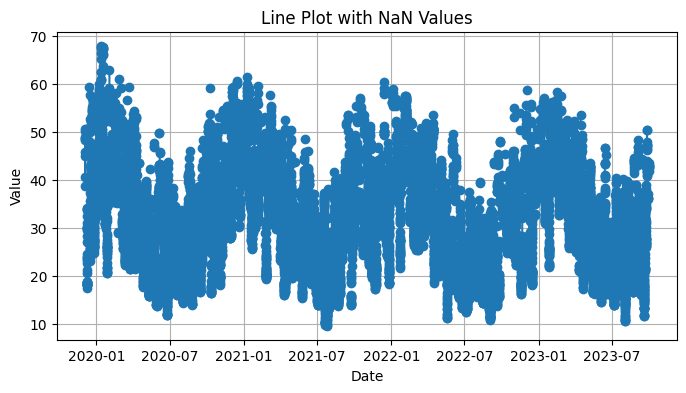

In [109]:
import pandas as pd
import matplotlib.pyplot as plt



# Plot the 'Value' column
plt.figure(figsize=(8, 4))  # Optional: Set the figure size
plt.plot(hourly_avg_df.index, hourly_avg_df['TPW'], marker='o', linestyle='-')
plt.title('Line Plot with NaN Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [110]:
hourly_avg_df.shape

(33541, 1)

In [113]:
# Count the number of NaN values in the 'Value' column
hourly_avg_df['TPW'].isna().sum()

15904

In [120]:
df['tpw_value'].isna().sum(), df.shape

(57194, (104455, 3))

In [121]:
df = pd.read_parquet('../data/goes16/tpw/tpw_2023-01-01_to_2023-05-31.parquet')
df.head()

,timestamp,station_id,tpw_value
0,202301010000,A636,NaN
1,202301010000,A621,NaN
2,202301010000,A602,NaN
3,202301010000,A652,NaN
4,202301010000,A627,NaN


In [182]:
df_wsoi = pd.read_parquet('../data/goes16/wsoi/A652.parquet')
df_wsoi.head(30)

,tpw_value
timestamp,
2019-12-03 14:00:00,NaN
2019-12-03 15:00:00,NaN
2019-12-03 16:00:00,NaN
2019-12-03 17:00:00,NaN
2019-12-03 18:00:00,NaN
2019-12-03 19:00:00,NaN
2019-12-03 20:00:00,NaN
2019-12-03 21:00:00,NaN
2019-12-03 22:00:00,NaN


In [175]:
df_wsoi.shape[0], df_wsoi['tpw_value'].isna().sum()

(30611, 18851)

In [176]:
df_wsoi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30611 entries, 2019-12-03 14:00:00 to 2023-06-01 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tpw_value  11760 non-null  float32
dtypes: float32(1)
memory usage: 358.7 KB


In [177]:
df_wsoi.index

DatetimeIndex(['2019-12-03 14:00:00', '2019-12-03 15:00:00',
               '2019-12-03 16:00:00', '2019-12-03 17:00:00',
               '2019-12-03 18:00:00', '2019-12-03 19:00:00',
               '2019-12-03 20:00:00', '2019-12-03 21:00:00',
               '2019-12-03 22:00:00', '2019-12-03 23:00:00',
               ...
               '2023-05-31 15:00:00', '2023-05-31 16:00:00',
               '2023-05-31 17:00:00', '2023-05-31 18:00:00',
               '2023-05-31 19:00:00', '2023-05-31 20:00:00',
               '2023-05-31 21:00:00', '2023-05-31 22:00:00',
               '2023-05-31 23:00:00', '2023-06-01 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=30611, freq=None)

In [179]:
df_wsoi.head(35)

,tpw_value
timestamp,
2019-12-03 14:00:00,NaN
2019-12-03 15:00:00,NaN
2019-12-03 16:00:00,NaN
2019-12-03 17:00:00,NaN
2019-12-03 18:00:00,NaN
2019-12-03 19:00:00,NaN
2019-12-03 20:00:00,NaN
2019-12-03 21:00:00,NaN
2019-12-03 22:00:00,NaN


In [180]:
import pandas as pd

import numpy as np

 

def compute_hourly_average(df):

    # Resample the DataFrame to hourly frequency and compute the mean

    df_resampled = df['tpw'].resample('H').mean()

   

    # Drop rows with NaN values in 'tpw'

    # df_resampled = df_resampled.dropna()

   

    return pd.DataFrame({'tpw': df_resampled.values},

                        index=df_resampled.index + pd.DateOffset(hours=1))

 

# Example usage

df_time = pd.DataFrame({'tpw': [0, 1, 2, np.nan, 4, 5, 3, 4, 3, np.nan, 4, 0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0, 0, 0, np.nan, 0, 0]},

                        index=[

                            pd.Timestamp('20130101 09:00:00'),

                            pd.Timestamp('20130101 09:10:00'),

                            pd.Timestamp('20130101 09:20:00'),

                            pd.Timestamp('20130101 09:30:00'),

                            pd.Timestamp('20130101 09:40:00'),

                            pd.Timestamp('20130101 09:50:00'),

                            pd.Timestamp('20130101 10:00:00'),

                            pd.Timestamp('20130101 10:10:00'),

                            pd.Timestamp('20130101 10:20:00'),

                            pd.Timestamp('20130101 10:30:00'),

                            pd.Timestamp('20130101 10:40:00'),

                            pd.Timestamp('20130101 10:50:00'),

                            pd.Timestamp('20130101 11:00:00'),

                            pd.Timestamp('20130101 11:10:00'),

                            pd.Timestamp('20130101 11:20:00'),

                            pd.Timestamp('20130101 11:30:00'),

                            pd.Timestamp('20130101 11:40:00'),

                            pd.Timestamp('20130101 11:50:00'),

                            pd.Timestamp('20130101 12:00:00'),

                            pd.Timestamp('20130101 12:10:00'),

                            pd.Timestamp('20130101 12:20:00'),

                            pd.Timestamp('20130101 12:30:00'),

                            pd.Timestamp('20130101 12:40:00'),

                            pd.Timestamp('20130101 12:50:00')

                            ])

 

df_time1 = compute_hourly_average(df_time)

print(df_time1)

                     tpw
2013-01-01 10:00:00  2.4
2013-01-01 11:00:00  2.8
2013-01-01 12:00:00  NaN
2013-01-01 13:00:00  0.0


# XGBoost

In [2]:
# %load ../src/globals.py
INMET_API_BASE_URL = "https://apitempo.inmet.gov.br"

# Weather stations datasource directories
WS_INMET_DATA_DIR = "./data/ws/inmet/"
WS_ALERTARIO_DATA_DIR = "./data/ws/alertario/ws/"
GS_ALERTARIO_DATA_DIR = "./data/ws/alertario/rain_gauge_era5_fused/"

WS_GOES_DATA_DIR = "atmoseer/data/ws/goes16"

# Atmospheric sounding datasource directory
NWP_DATA_DIR = "./data/NWP/"

# Atmospheric sounding datasource directory
AS_DATA_DIR = "./data/as/"

# TPW GOES16 datasource directory
TPW_DATA_DIR = "./data/goes16/wsoi"

# Directory to store the train/val/test datasets for each weather station of interest
DATASETS_DIR = './data/datasets/'

# Directory to store the generated models and their corresponding reports
MODELS_DIR = './models/'

# see https://portal.inmet.gov.br/paginas/catalogoaut
INMET_WEATHER_STATION_IDS = (
    'A636', # Jacarepagua
    'A621', # Vila militar
    'A602', # Marambaia
    'A652', # Forte de Copacabana
    'A627'  # Niteroi
)

ALERTARIO_GAUGE_STATION_IDS = (
                         'anchieta', 
                         'av_brasil_mendanha', 
                         'bangu', 
                         'barrinha', 
                         'campo_grande', 
                         'cidade_de_deus', 
                         'copacabana', 
                         'grajau_jacarepagua', 
                         'grajau', 
                         'grande_meier', 
                         'grota_funda', 
                         'ilha_do_governador', 
                         'laranjeiras', 
                         'madureira', 
                         'penha', 
                         'piedade', 
                         'recreio', 
                         'rocinha',
                         'santa_teresa',
                         'saude', 
                         'sepetiba', 
                         'tanque', 
                         'tijuca_muda', 
                         'tijuca', 
                         'urca',
                         'alto_da_boa_vista', #**
                         'iraja', #**
                         'jardim_botanico', #**
                         'riocentro', #**
                         'santa_cruz', #**
                         'vidigal' #**
                         )

ALERTARIO_WEATHER_STATION_IDS = (
                         'guaratiba', #**
                         'sao_cristovao' #**
                         )

# hyper_params_dict_bc = {
#     "N_EPOCHS" : 3500,
#     "PATIENCE" : 1000,
#     "BATCH_SIZE" : 1024,
#     "WEIGHT_DECAY" : 0,
#     "LEARNING_RATE" : 0.0003,
#     "DROPOUT_RATE" : 0.5,
#     "SLIDING_WINDOW_SIZE" : 6
# }

# hyper_params_dict_oc = {
#     "N_EPOCHS" : 6000,
#     "PATIENCE" : 1000,
#     "BATCH_SIZE" : 1024,
#     "WEIGHT_DECAY" : 0,
#     "LEARNING_RATE" : 3e-6,
#     "DROPOUT_RATE" : 0.5,
#     "SLIDING_WINDOW_SIZE" : 6
# }


# Observed variables for INMET weather stations:
# ,DC_NOME,
# PRE_INS,
# TEM_SEN,
# VL_LATITUDE,
# PRE_MAX,UF,
# RAD_GLO,
# PTO_INS,
# TEM_MIN,
# VL_LONGITUDE,
# UMD_MIN,
# PTO_MAX,
# VEN_DIR,
# DT_MEDICAO,
# CHUVA,
# PRE_MIN,
# UMD_MAX,
# VEN_VEL,
# PTO_MIN,
# TEM_MAX,
# TEN_BAT,
# VEN_RAJ,
# TEM_CPU,
# TEM_INS,
# UMD_INS,
# CD_ESTACAO,
# HR_MEDICAO

In [4]:
import numpy as np
import pickle

for station in INMET_WEATHER_STATION_IDS:
    filename = f"../data/datasets/{station}.pickle"
    print(f"Loading train/val/test datasets from {filename}.")
    file = open(filename, 'rb')
    (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)

    print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")

    print(f"Shapes before reshaping: ", X_train.shape, X_val.shape, X_test.shape)
    X_train = X_train.reshape(len(X_train), -1)
    X_val = X_val.reshape(len(X_val), -1)
    X_test = X_test.reshape(len(X_test), -1)
    print(f"Shapes after reshaping: ", X_train.shape, X_val.shape, X_test.shape)

    ndarrays = (X_train, y_train, 
                X_val, y_val, 
                X_test, y_test)
    outfilename = f'./{station}.pickle'
    file = open(outfilename, 'wb')
    pickle.dump(ndarrays, file)

    file = open(outfilename, 'rb')
    (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
    print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

print('Success!')


Loading train/val/test datasets from ../data/datasets/A636.pickle.
Shapes of train/val/test data matrices: (10219, 3, 8)/(2414, 3, 8)/(10129, 3, 8)
Shapes before reshaping:  (10219, 3, 8) (2414, 3, 8) (10129, 3, 8)
Shapes after reshaping:  (10219, 24) (2414, 24) (10129, 24)
Shapes:  (10219, 24) (2414, 24) (10129, 24)
Loading train/val/test datasets from ../data/datasets/A621.pickle.
Shapes of train/val/test data matrices: (9549, 3, 8)/(2428, 3, 8)/(10080, 3, 8)
Shapes before reshaping:  (9549, 3, 8) (2428, 3, 8) (10080, 3, 8)
Shapes after reshaping:  (9549, 24) (2428, 24) (10080, 24)
Shapes:  (9549, 24) (2428, 24) (10080, 24)
Loading train/val/test datasets from ../data/datasets/A602.pickle.
Shapes of train/val/test data matrices: (10178, 3, 8)/(2565, 3, 8)/(765, 3, 8)
Shapes before reshaping:  (10178, 3, 8) (2565, 3, 8) (765, 3, 8)
Shapes after reshaping:  (10178, 24) (2565, 24) (765, 24)
Shapes:  (10178, 24) (2565, 24) (765, 24)
Loading train/val/test datasets from ../data/datasets/A

In [10]:
# %load ../src/train/xgboost.py
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report

def _train_and_test_classifier(X_train, y_train, X_test, y_test):

    print(f"Shapes before reshaping: ", X_train.shape, X_test.shape)
    X_train = X_train.reshape(len(X_train), -1)
    X_test = X_test.reshape(len(X_test), -1)
    print(f"Shapes after reshaping: ", X_train.shape, X_test.shape)

    y_train[y_train>0] = 1
    y_test[y_test>0] = 1

    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    
    y_true = y_test
    y_true[y_true>0] = 1

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return cm, y_true, y_pred

def report_results(cm, y_true, y_pred, title = None):
    # Define the class labels
    class_names = ['Negative', 'Positive']

    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    if title is not None:
        plt.title('Confusion Matrix - ' + title)
    else:
        plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Build the classification report
    target_names = ['Negative', 'Positive']
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Print the classification report
    print(report)

def train_and_test_classifier(pipeline_id):
    filename = f"../data/datasets/{pipeline_id}.pickle"
    print(f"Loading train/val/test datasets from {filename}.")
    file = open(filename, 'rb')
    (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
    print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")
    cm, y_true, y_pred = _train_and_test_classifier(X_train, y_train, X_test, y_test)
    report_results(cm, y_true, y_pred, pipeline_id)

Loading train/val/test datasets from ../data/datasets/A636.pickle.
Shapes of train/val/test data matrices: (10219, 3, 8)/(2414, 3, 8)/(10129, 3, 8)
Shapes before reshaping:  (10219, 3, 8) (10129, 3, 8)
Shapes after reshaping:  (10219, 24) (10129, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


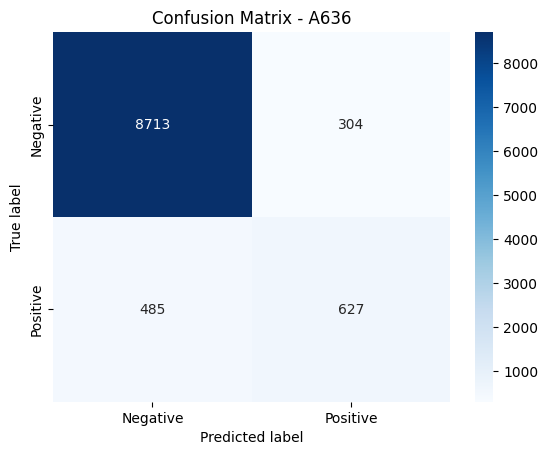

              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96      9017
    Positive       0.67      0.56      0.61      1112

    accuracy                           0.92     10129
   macro avg       0.81      0.77      0.79     10129
weighted avg       0.92      0.92      0.92     10129

Loading train/val/test datasets from ../data/datasets/A636_T.pickle.
Shapes of train/val/test data matrices: (10219, 3, 10)/(2414, 3, 10)/(10129, 3, 10)
Shapes before reshaping:  (10219, 3, 10) (10129, 3, 10)
Shapes after reshaping:  (10219, 30) (10129, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


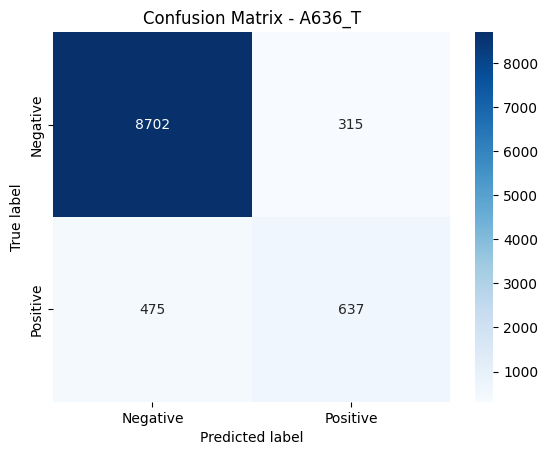

              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96      9017
    Positive       0.67      0.57      0.62      1112

    accuracy                           0.92     10129
   macro avg       0.81      0.77      0.79     10129
weighted avg       0.92      0.92      0.92     10129

Loading train/val/test datasets from ../data/datasets/A621.pickle.
Shapes of train/val/test data matrices: (9549, 3, 8)/(2428, 3, 8)/(10080, 3, 8)
Shapes before reshaping:  (9549, 3, 8) (10080, 3, 8)
Shapes after reshaping:  (9549, 24) (10080, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


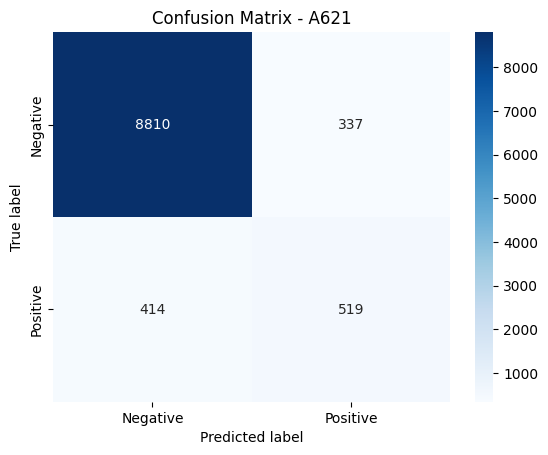

              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96      9147
    Positive       0.61      0.56      0.58       933

    accuracy                           0.93     10080
   macro avg       0.78      0.76      0.77     10080
weighted avg       0.92      0.93      0.92     10080

Loading train/val/test datasets from ../data/datasets/A621_T.pickle.
Shapes of train/val/test data matrices: (9549, 3, 10)/(2428, 3, 10)/(10080, 3, 10)
Shapes before reshaping:  (9549, 3, 10) (10080, 3, 10)
Shapes after reshaping:  (9549, 30) (10080, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


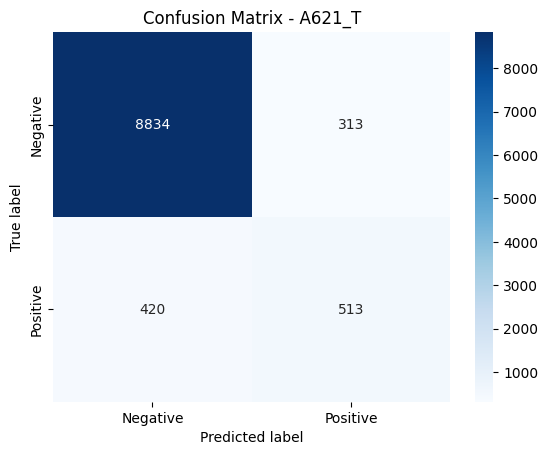

              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96      9147
    Positive       0.62      0.55      0.58       933

    accuracy                           0.93     10080
   macro avg       0.79      0.76      0.77     10080
weighted avg       0.92      0.93      0.93     10080

Loading train/val/test datasets from ../data/datasets/A602.pickle.
Shapes of train/val/test data matrices: (10178, 3, 8)/(2565, 3, 8)/(765, 3, 8)
Shapes before reshaping:  (10178, 3, 8) (765, 3, 8)
Shapes after reshaping:  (10178, 24) (765, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


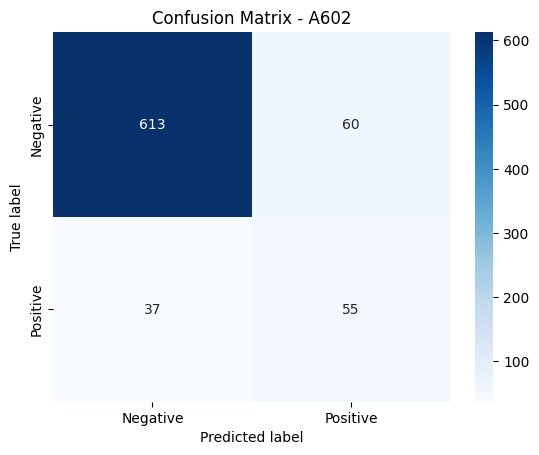

              precision    recall  f1-score   support

    Negative       0.94      0.91      0.93       673
    Positive       0.48      0.60      0.53        92

    accuracy                           0.87       765
   macro avg       0.71      0.75      0.73       765
weighted avg       0.89      0.87      0.88       765

Loading train/val/test datasets from ../data/datasets/A602_T.pickle.
Shapes of train/val/test data matrices: (10178, 3, 10)/(2565, 3, 10)/(765, 3, 10)
Shapes before reshaping:  (10178, 3, 10) (765, 3, 10)
Shapes after reshaping:  (10178, 30) (765, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


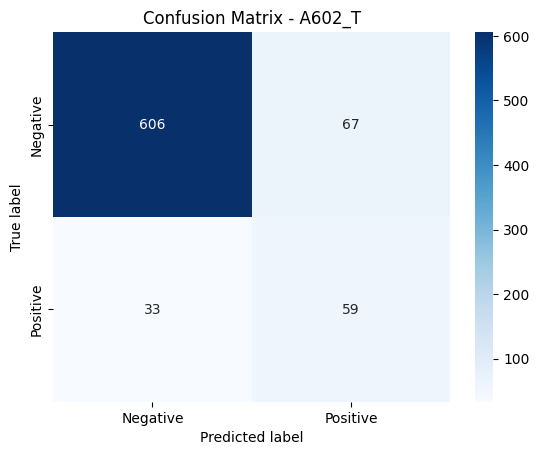

              precision    recall  f1-score   support

    Negative       0.95      0.90      0.92       673
    Positive       0.47      0.64      0.54        92

    accuracy                           0.87       765
   macro avg       0.71      0.77      0.73       765
weighted avg       0.89      0.87      0.88       765

Loading train/val/test datasets from ../data/datasets/A652.pickle.
Shapes of train/val/test data matrices: (10012, 3, 8)/(2506, 3, 8)/(9582, 3, 8)
Shapes before reshaping:  (10012, 3, 8) (9582, 3, 8)
Shapes after reshaping:  (10012, 24) (9582, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


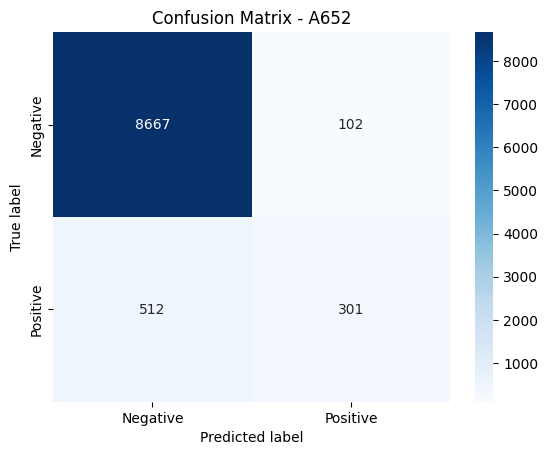

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97      8769
    Positive       0.75      0.37      0.50       813

    accuracy                           0.94      9582
   macro avg       0.85      0.68      0.73      9582
weighted avg       0.93      0.94      0.93      9582

Loading train/val/test datasets from ../data/datasets/A652_T.pickle.
Shapes of train/val/test data matrices: (10012, 3, 10)/(2506, 3, 10)/(9582, 3, 10)
Shapes before reshaping:  (10012, 3, 10) (9582, 3, 10)
Shapes after reshaping:  (10012, 30) (9582, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


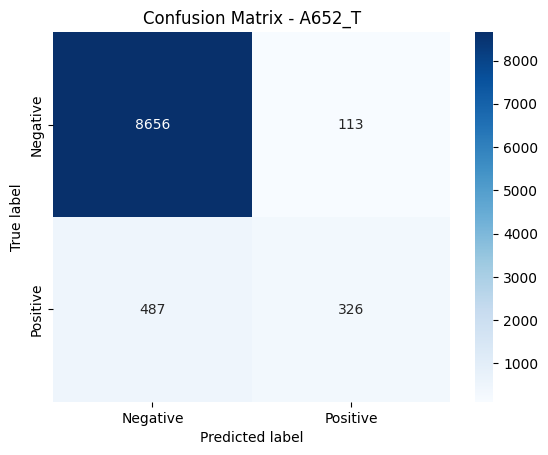

              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97      8769
    Positive       0.74      0.40      0.52       813

    accuracy                           0.94      9582
   macro avg       0.84      0.69      0.74      9582
weighted avg       0.93      0.94      0.93      9582

Loading train/val/test datasets from ../data/datasets/A627.pickle.
Shapes of train/val/test data matrices: (9682, 3, 8)/(2235, 3, 8)/(10202, 3, 8)
Shapes before reshaping:  (9682, 3, 8) (10202, 3, 8)
Shapes after reshaping:  (9682, 24) (10202, 24)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


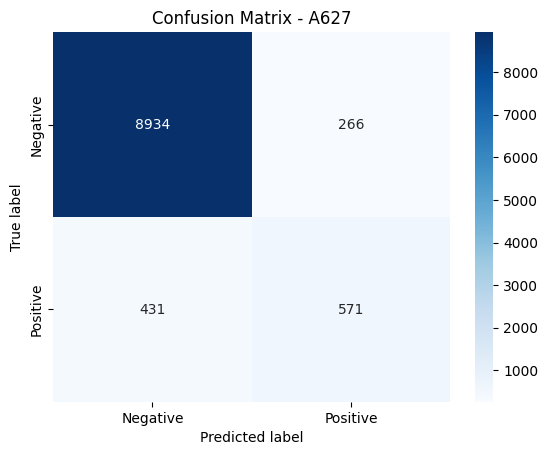

              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96      9200
    Positive       0.68      0.57      0.62      1002

    accuracy                           0.93     10202
   macro avg       0.82      0.77      0.79     10202
weighted avg       0.93      0.93      0.93     10202

Loading train/val/test datasets from ../data/datasets/A627_T.pickle.
Shapes of train/val/test data matrices: (9682, 3, 10)/(2235, 3, 10)/(10202, 3, 10)
Shapes before reshaping:  (9682, 3, 10) (10202, 3, 10)
Shapes after reshaping:  (9682, 30) (10202, 30)


/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


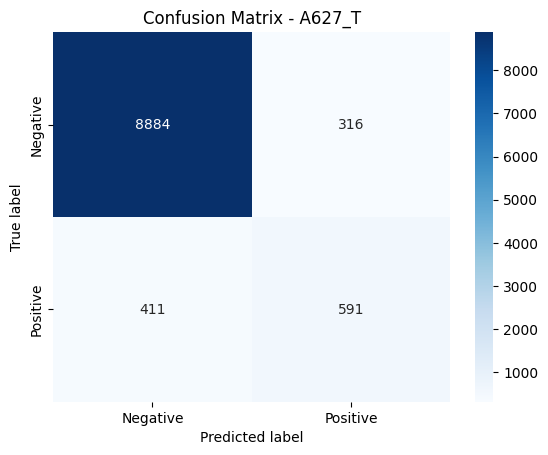

              precision    recall  f1-score   support

    Negative       0.96      0.97      0.96      9200
    Positive       0.65      0.59      0.62      1002

    accuracy                           0.93     10202
   macro avg       0.80      0.78      0.79     10202
weighted avg       0.93      0.93      0.93     10202



In [11]:
for station in INMET_WEATHER_STATION_IDS:
    train_and_test_classifier(station)
    train_and_test_classifier(station + '_T')